# Post-Block Survey

In [216]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import plot_likert
import scikit_posthocs as ph
import scipy.stats as stats
import seaborn as sns
import math

%env OUTDATED_IGNORE=1
%run ./Plots.ipynb

sns.set_context("notebook")
sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['patch.linewidth'] = 0.0

palette = sns.color_palette("magma", 4)

env: OUTDATED_IGNORE=1


# 1. Read Data

In [217]:
# Read raw data
df = pd.read_excel("PostTask.xlsx")

# Drop unused columns
df.drop(df.filter(regex='Start time').columns, axis=1, inplace=True)
df.drop(df.filter(regex='Completion time').columns, axis=1, inplace=True)
df.drop(df.filter(regex='Email').columns, axis=1, inplace=True)
df.drop(df.filter(regex='Name').columns, axis=1, inplace=True)

# Rename columns
df.columns = ["Row", "Participant", "Task", "Technique",
              "Acquire", "Control", "Move", "Disengage", "Satisfaction", "Retain", "Responsive",
              "TLX_Mental", "TLX_Physical", "TLX_Temporal", "TLX_Performance", "TLX_Effort", "TLX_Frustration"]

# Replace Likert scale text with numbers
df.replace({"Very Strongly Disagree": 1, "Strongly Disagree": 2, "Disagree": 3, "Neither Agree or Disagree": 4,
           "Agree": 5, "Strongly Agree": 6, "Very Strongly Agree": 7}, inplace=True)

# Replace condition and task names
df.replace({"Touch In The Air": "AirTouch", "Pinch On Circle": "Pinch", "Pinch Anywhere": "PinchAnywhere"}, inplace=True)
df.replace({"Digit Selector": "Digit", "Letter Selector": "Letter", "Shape Scaler": "Shape"}, inplace=True)

# Calculate total task-load index
df["TLX"] = (df.TLX_Mental + df.TLX_Physical + df.TLX_Temporal + df.TLX_Performance + df.TLX_Effort + df.TLX_Frustration) / 60.0 * 100

df = df[df["Participant"] > 4]

n = len(df.Participant.unique())

print("Read data from {} participants".format(n,))

Read data from 15 participants


In [218]:
def confidence(dataframe, group):
    group = dataframe[group]
    upper = group.mean() + 1.96 * (group.std()/math.sqrt(group.count()))
    lower = group.mean() - 1.96 * (group.std()/math.sqrt(group.count()))
    return "Mean: " + str(group.mean()) + ", StDev: " + str(group.std()) + ", 95% confidence: [" + str(lower) + ", " + str(upper) + "]"

# 2. TLX


In [219]:
# Aggregate mean TLX data per participant
df_tlx = df.groupby(["Participant", "Technique"]).aggregate({"TLX": "mean",
                                                  "TLX_Mental": "mean",
                                                  "TLX_Physical": "mean",
                                                  "TLX_Temporal": "mean",
                                                  "TLX_Performance": "mean",
                                                  "TLX_Effort": "mean",
                                                  "TLX_Frustration": "mean"}).reset_index()

# Create separate arrays for each technique
df_airtouch = df_tlx[df_tlx['Technique'] == "AirTouch"]
df_dwell    = df_tlx[df_tlx['Technique'] == "Dwell"]
df_pinch    = df_tlx[df_tlx['Technique'] == "Pinch"]
df_pinchany = df_tlx[df_tlx['Technique'] == "PinchAnywhere"]

## 2.1 Plot TLX Data

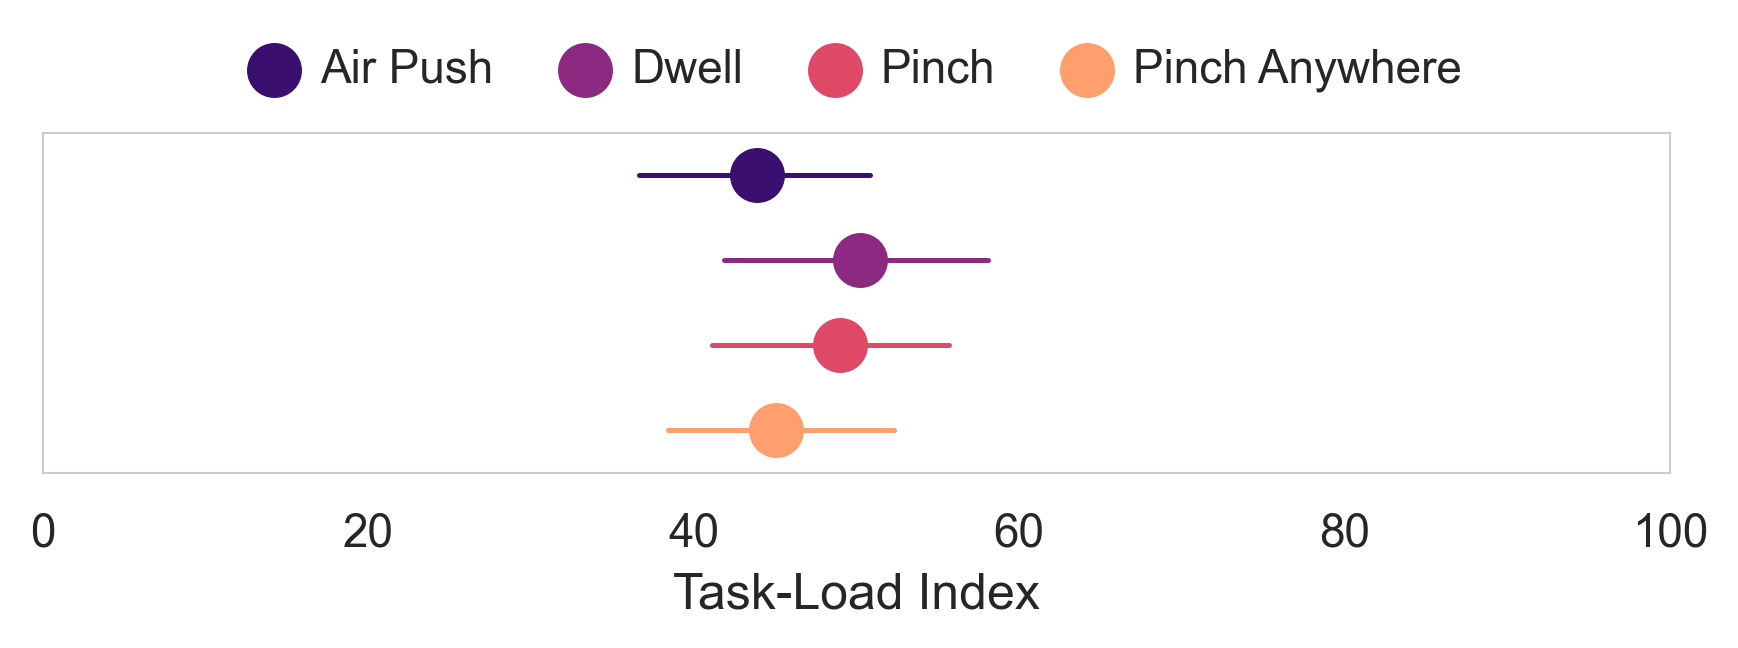

In [220]:
plot_tlx, axis = stripplot(df_tlx, iv="Technique", dv="TLX", n_iv=4, size=(7, 1.5), show_all=False, xlab="Task-Load Index", hide_legend=False)
axis.set(xlim=(0, 100))

plot_tlx.savefig("Plots/TLX-Technique.pdf", bbox_inches='tight')

[(0.0, 100.0)]

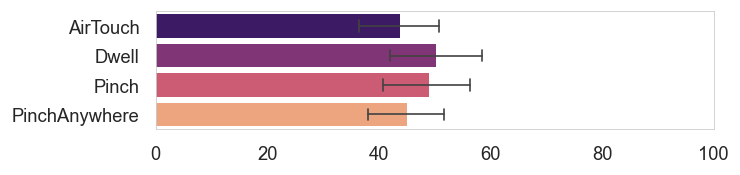

In [186]:
plot, axis = barplot_one_factor(df_tlx, iv="Technique", dv="TLX")
axis.set(xlim=(0, 100))

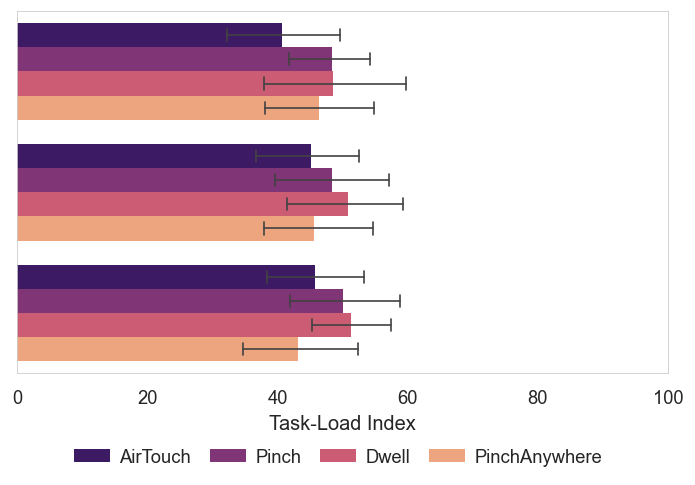

In [187]:
plot, axis = barplot_two_factor(df, iv1="Task", iv2="Technique", dv="TLX", xlab="Task-Load Index", hide_grid=True, hide_legend=False, size=(7, 4))
axis.set(xlim=(0, 100))
axis.legend(handletextpad=0.5, columnspacing=1, loc="lower center", ncol=4, frameon=False, bbox_to_anchor=(0.493, -0.3))

## 2.2 TLX Analysis

In [188]:
def friedman_tlx(iv="Technique", dv="TLX"):
    """
    Performs a friedman test and, if relevant, post hoc comparisons.
    
    Params:
        iv: Column containing independent variable.
        dv: Column containing dependent variable values for comparison.
    """
    result     = stats.friedmanchisquare(df_airtouch[dv], df_dwell[dv], df_pinch[dv], df_pinchany[dv])
    result_str = friedman_to_LaTeX(result)
    
    print(dv + "\n" + result_str + "\n")
    
    if result[1] < 0.05:
        ph_result     = ph.posthoc_nemenyi_friedman(df_tlx, y_col=dv, group_col=iv, block_col="Participant", melted=True)
        ph_result_str = nemenyi_to_LaTeX(ph_result)
        print(ph_result)
        print(ph_result_str)

In [189]:
confidence(df_tlx, "TLX")

'Mean: 47.037037037037045, StDev: 15.046717604802172, 95% confidence: [43.22969217273604, 50.84438190133805]'

In [190]:
friedman_tlx(iv="Technique", dv="TLX")
friedman_tlx(iv="Technique", dv="TLX_Mental")
friedman_tlx(iv="Technique", dv="TLX_Physical")
friedman_tlx(iv="Technique", dv="TLX_Temporal")
friedman_tlx(iv="Technique", dv="TLX_Performance")
friedman_tlx(iv="Technique", dv="TLX_Effort")
friedman_tlx(iv="Technique", dv="TLX_Frustration")

TLX
$\chi^2 = 8.40, p = 0.038$

               AirTouch     Dwell     Pinch  PinchAnywhere
AirTouch       1.000000  0.090431  0.090431       0.888247
Dwell          0.090431  1.000000  0.900000       0.364388
Pinch          0.090431  0.900000  1.000000       0.364388
PinchAnywhere  0.888247  0.364388  0.364388       1.000000

TLX_Mental
$\chi^2 = 12.40, p = 0.006$

               AirTouch     Dwell     Pinch  PinchAnywhere
AirTouch       1.000000  0.019591  0.015778       0.448046
Dwell          0.019591  1.000000  0.900000       0.490749
Pinch          0.015778  0.900000  1.000000       0.448046
PinchAnywhere  0.448046  0.490749  0.448046       1.000000
AirTouch vs Dwell p = 0.020
AirTouch vs Pinch p = 0.016

TLX_Physical
$\chi^2 = 6.44, p = 0.092$

TLX_Temporal
$\chi^2 = 4.18, p = 0.243$

TLX_Performance
$\chi^2 = 1.16, p = 0.764$

TLX_Effort
$\chi^2 = 8.76, p = 0.033$

               AirTouch     Dwell     Pinch  PinchAnywhere
AirTouch       1.000000  0.090431  0.125210       0.9000

# 3. Likert scales

In [191]:
# Aggregate survey responses per participant - take median across the different tasks
df_likert = df.groupby(["Participant", "Technique"]).aggregate({"Acquire": "median", "Control": "median", "Move": "median", "Disengage": "median", "Satisfaction": "median", "Retain": "median", "Responsive": "median"}).reset_index()

# Create separate arrays for each technique
df_airtouch = df_likert[df_likert['Technique'] == "AirTouch"]
df_dwell    = df_likert[df_likert['Technique'] == "Dwell"]
df_pinch    = df_likert[df_likert['Technique'] == "Pinch"]
df_pinchany = df_likert[df_likert['Technique'] == "PinchAnywhere"]

# Initialise render parameters for the Likert plots
plt.rcParams['patch.linewidth'] = 0.0
plt.rcParams['lines.linewidth'] = 1.0

# Set up Likert plot values
scale_labels = ["1 Strongly Disagree", "2 Disagree", "3 Slightly Disagree", "4 Neutral", "5 Slightly Agree", "6 Agree", "7 Strongly Agree"]
likert_palette = [(1., 1., 1., 0.)] + sns.color_palette("magma", 7)
questions = ["Acquire", "Control", "Move", "Disengage", "Satisfaction", "Retain", "Responsive"]

## 3.1 Air Push

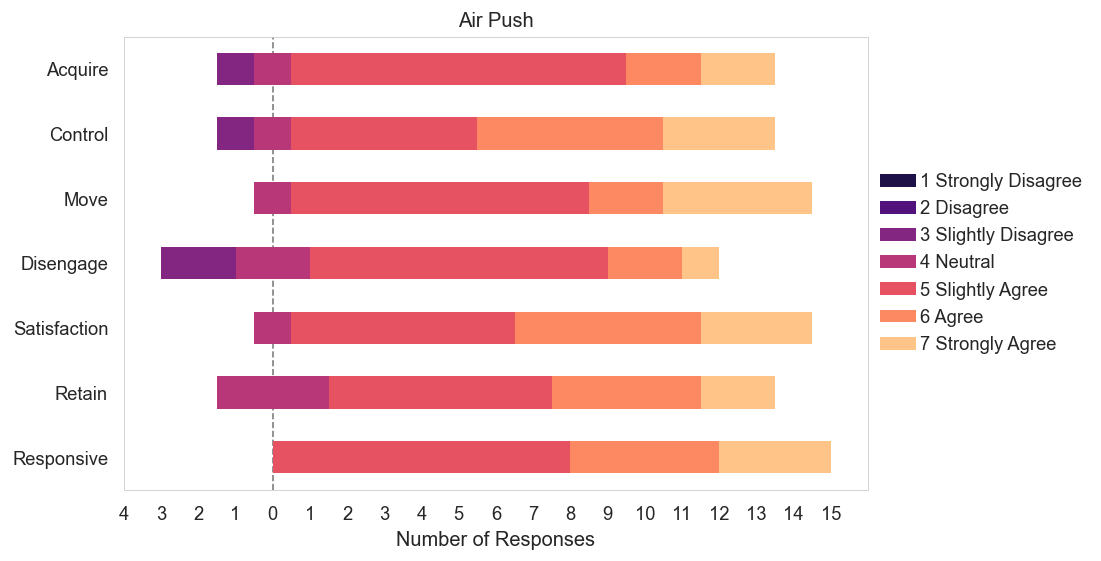

In [192]:
axis = plot_likert.plot_likert(df_airtouch[questions], [1, 2, 3, 4, 5, 6, 7], plot_percentage=False, colors=likert_palette, figsize=(8, 5));
plt.title("Air Push")
axis.grid(False)
handles, _ = axis.get_legend_handles_labels()
axis.legend(handles, scale_labels, handletextpad=0.2, columnspacing=0.8, loc="center right", ncol=1, frameon=False, bbox_to_anchor=(1.31, 0.5))

plt.savefig("Plots/AirPush.pdf", bbox_inches='tight')

In [208]:
df_airtouch[questions].mean()

Acquire         5.200000
Control         5.533333
Move            5.600000
Disengage       4.866667
Satisfaction    5.666667
Retain          5.333333
Responsive      5.666667
dtype: float64

In [206]:
df_airtouch[questions].iqr()

AttributeError: 'DataFrame' object has no attribute 'iqr'

In [195]:
questions = ["Acquire", "Control", "Move", "Disengage", "Satisfaction", "Retain", "Responsive"]
for q in questions:
    print(confidence(df_airtouch[questions], q))


Mean: 5.2, StDev: 1.01418510567422, 95% confidence: [4.686751522164946, 5.713248477835054]
Mean: 5.533333333333333, StDev: 1.1254628677422756, 95% confidence: [4.9637705380440185, 6.102896128622648]
Mean: 5.6, StDev: 0.9856107606091623, 95% confidence: [5.101212135940203, 6.098787864059796]
Mean: 4.866666666666666, StDev: 1.0600988273786192, 95% confidence: [4.330182639773869, 5.403150693559463]
Mean: 5.666666666666667, StDev: 0.8997354108424372, 95% confidence: [5.21133772574105, 6.121995607592284]
Mean: 5.333333333333333, StDev: 0.9759000729485332, 95% confidence: [4.839459755267943, 5.827206911398723]
Mean: 5.666666666666667, StDev: 0.816496580927726, 95% confidence: [5.253462385737999, 6.079870947595335]


## 3.2 Dwell

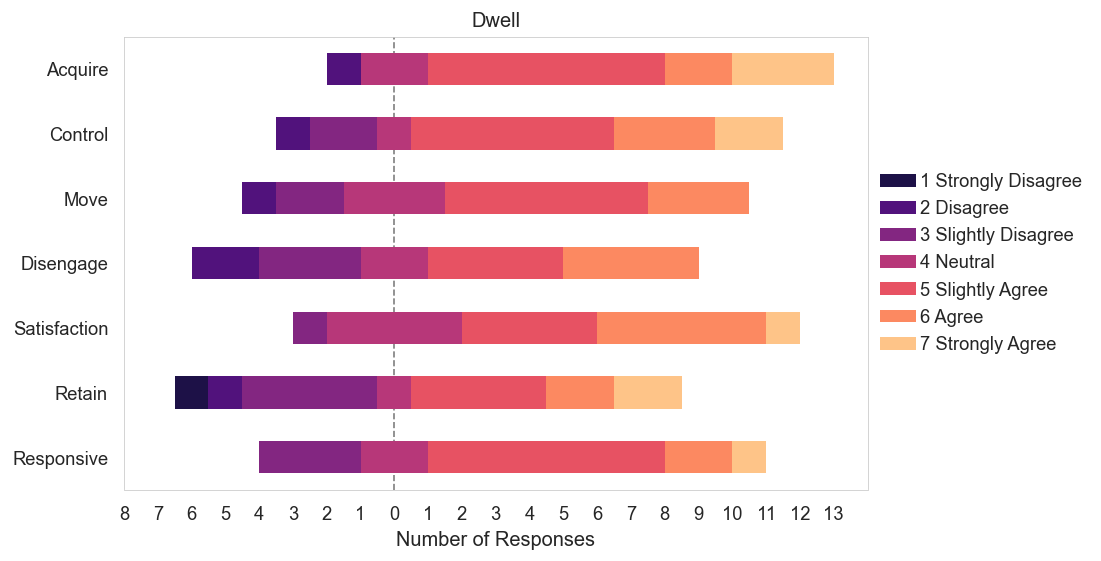

In [196]:
axis = plot_likert.plot_likert(df_dwell[questions], [1, 2, 3, 4, 5, 6, 7], plot_percentage=False, colors=likert_palette, figsize=(8, 5));
plt.title("Dwell")
axis.grid(False)
handles, _ = axis.get_legend_handles_labels()
axis.legend(handles, scale_labels, handletextpad=0.2, columnspacing=0.8, loc="center right", ncol=1, frameon=False, bbox_to_anchor=(1.31, 0.5))

plt.savefig("Plots/Dwell.pdf", bbox_inches='tight')

In [197]:
questions = ["Acquire", "Control", "Move", "Disengage", "Satisfaction", "Retain", "Responsive"]
for q in questions:
    print(confidence(df_dwell[questions], q))


Mean: 5.2, StDev: 1.3201731488169053, 95% confidence: [4.531900207054864, 5.868099792945136]
Mean: 4.933333333333334, StDev: 1.4375905768565218, 95% confidence: [4.2058121232568775, 5.66085454340979]
Mean: 4.533333333333333, StDev: 1.1872336794093272, 95% confidence: [3.9325101942612397, 5.134156472405427]
Mean: 4.333333333333333, StDev: 1.4474937289114918, 95% confidence: [3.6008004368403195, 5.065866229826347]
Mean: 5.066666666666666, StDev: 1.0997835284835875, 95% confidence: [4.510099410073979, 5.623233923259354]
Mean: 4.333333333333333, StDev: 1.7994708216848747, 95% confidence: [3.422675451482098, 5.243991215184568]
Mean: 4.733333333333333, StDev: 1.162919151265879, 95% confidence: [4.144815043237114, 5.321851623429553]


In [198]:
df_dwell[questions].std()

Acquire         1.320173
Control         1.437591
Move            1.187234
Disengage       1.447494
Satisfaction    1.099784
Retain          1.799471
Responsive      1.162919
dtype: float64

## 3.3 Pinch

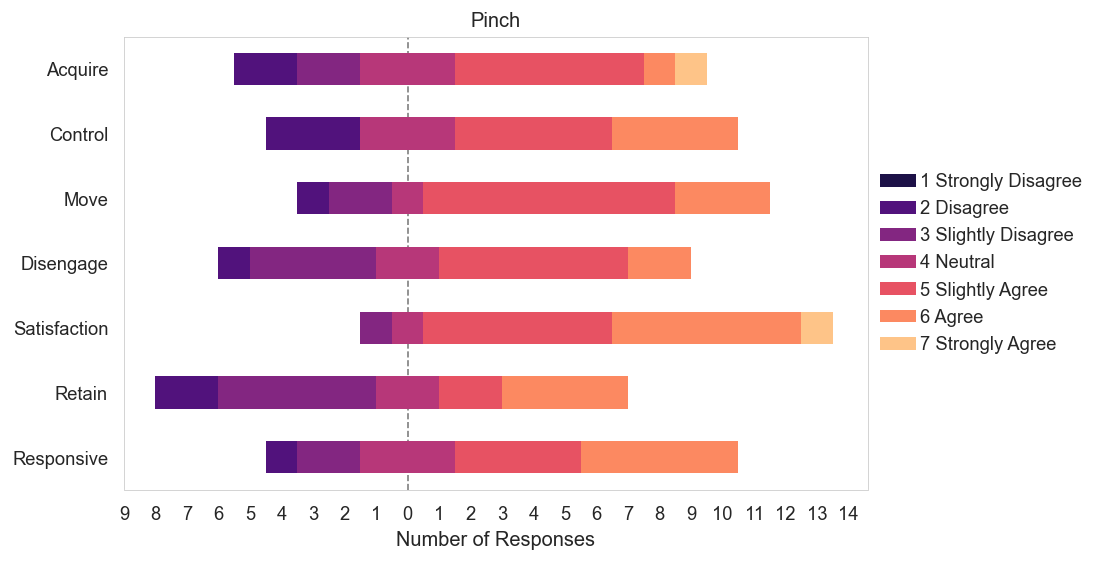

In [199]:
axis = plot_likert.plot_likert(df_pinch[questions], [1, 2, 3, 4, 5, 6, 7], plot_percentage=False, colors=likert_palette, figsize=(8, 5));
plt.title("Pinch")
axis.grid(False)
handles, _ = axis.get_legend_handles_labels()
axis.legend(handles, scale_labels, handletextpad=0.2, columnspacing=0.8, loc="center right", ncol=1, frameon=False, bbox_to_anchor=(1.31, 0.5))

plt.savefig("Plots/Survey_Pinch.pdf", bbox_inches='tight')

In [200]:
questions = ["Acquire", "Control", "Move", "Disengage", "Satisfaction", "Retain", "Responsive"]
for q in questions:
    print(confidence(df_pinch[questions], q))

Mean: 4.333333333333333, StDev: 1.3972762620115438, 95% confidence: [3.626213981471303, 5.040452685195364]
Mean: 4.466666666666667, StDev: 1.4573295865416043, 95% confidence: [3.729156139434833, 5.2041771938985]
Mean: 4.666666666666667, StDev: 1.1751393027860062, 95% confidence: [4.0719641266425715, 5.2613692066907625]
Mean: 4.266666666666667, StDev: 1.2227992865708153, 95% confidence: [3.6478448470413043, 4.8854884862920285]
Mean: 5.333333333333333, StDev: 0.9759000729485331, 95% confidence: [4.839459755267943, 5.827206911398723]
Mean: 4.066666666666666, StDev: 1.486446705914413, 95% confidence: [3.314420843961231, 4.818912489372102]
Mean: 4.666666666666667, StDev: 1.2909944487358058, 95% confidence: [4.013333333333334, 5.32]


## 3.4 Pinch Anywhere

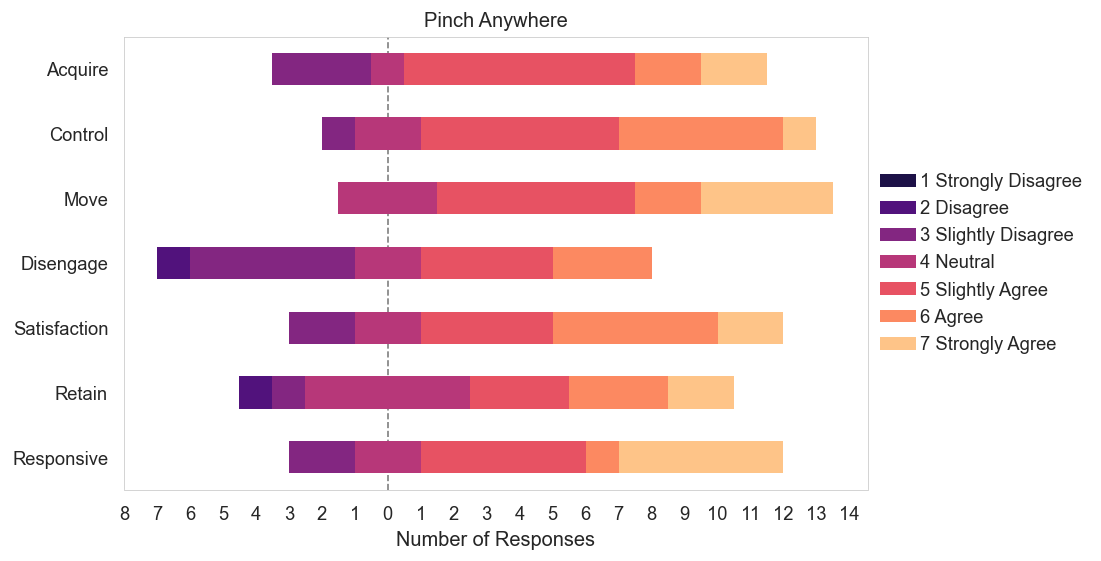

In [201]:
axis = plot_likert.plot_likert(df_pinchany[questions], [1, 2, 3, 4, 5, 6, 7], plot_percentage=False, colors=likert_palette, figsize=(8, 5));
plt.title("Pinch Anywhere")
axis.grid(False)
handles, _ = axis.get_legend_handles_labels()
axis.legend(handles, scale_labels, handletextpad=0.2, columnspacing=0.8, loc="center right", ncol=1, frameon=False, bbox_to_anchor=(1.31, 0.5))

plt.savefig("Plots/Survey_PinchAnywhere.pdf", bbox_inches='tight')

In [202]:
questions = ["Acquire", "Control", "Move", "Disengage", "Satisfaction", "Retain", "Responsive"]
for q in questions:
    print(confidence(df_pinchany[questions], q))

Mean: 4.933333333333334, StDev: 1.2798809468443688, 95% confidence: [4.285624207945161, 5.581042458721506]
Mean: 5.2, StDev: 1.01418510567422, 95% confidence: [4.686751522164946, 5.713248477835054]
Mean: 5.466666666666667, StDev: 1.1254628677422756, 95% confidence: [4.897103871377352, 6.0362294619559815]
Mean: 4.2, StDev: 1.3201731488169055, 95% confidence: [3.531900207054864, 4.868099792945136]
Mean: 5.2, StDev: 1.2649110640673518, 95% confidence: [4.559866680552663, 5.840133319447338]
Mean: 4.8, StDev: 1.424279266355945, 95% confidence: [4.079215242484508, 5.520784757515492]
Mean: 5.333333333333333, StDev: 1.4474937289114918, 95% confidence: [4.600800436840319, 6.065866229826347]


## Survey Analysis

In [215]:
def iqr(data):
    q3, q1 = np.percentile(data, [75 ,25])
    return q3 - q1

df_likert.groupby("Technique").aggregate({"Acquire": ["median", iqr], "Control": ["median", iqr], "Move": ["median", iqr], "Disengage": ["median", iqr], "Satisfaction": ["median", iqr], "Retain": ["median", iqr], "Responsive": ["median", iqr]}).reset_index()

Technique Acquire      Control        Move      Disengage       \
                  median  iqr  median  iqr median  iqr    median  iqr   
0       AirTouch     5.0  0.5     6.0  1.0    5.0  1.5       5.0  0.5   
1          Dwell     5.0  1.0     5.0  1.5    5.0  1.0       5.0  2.5   
2          Pinch     5.0  1.5     5.0  1.5    5.0  0.5       5.0  2.0   
3  PinchAnywhere     5.0  1.0     5.0  1.0    5.0  1.5       4.0  2.0   

  Satisfaction      Retain      Responsive       
        median  iqr median  iqr     median  iqr  
0          6.0  1.0    5.0  1.0        5.0  1.0  
1          5.0  2.0    5.0  2.5        5.0  1.0  
2          5.0  1.0    4.0  2.5        5.0  2.0  
3          5.0  1.5    5.0  2.0        5.0  2.5

In [203]:
def friedman_likert(iv="Technique", dv="Acquire"):
    """
    Performs a friedman test and, if relevant, post hoc comparisons.
    
    Params:
        iv: Column containing independent variable.
        dv: Column containing dependent variable values for comparison.
    """
    result     = stats.friedmanchisquare(df_airtouch[dv], df_dwell[dv], df_pinch[dv], df_pinchany[dv])
    result_str = friedman_to_LaTeX(result)
    
    print(dv + "\n" + result_str + "\n")
    
    if result[1] < 0.05:
        ph_result     = ph.posthoc_nemenyi_friedman(df_likert, y_col=dv, group_col=iv, block_col="Participant", melted=True)
        ph_result_str = nemenyi_to_LaTeX(ph_result)
        print(ph_result)
        print(ph_result_str)

In [204]:
friedman_likert(dv="Acquire")
friedman_likert(dv="Control")
friedman_likert(dv="Move")
friedman_likert(dv="Disengage")
friedman_likert(dv="Satisfaction")
friedman_likert(dv="Retain")
friedman_likert(dv="Responsive")

Acquire
$\chi^2 = 6.19, p = 0.103$

Control
$\chi^2 = 5.50, p = 0.138$

Move
$\chi^2 = 11.04, p = 0.012$

               AirTouch     Dwell     Pinch  PinchAnywhere
AirTouch       1.000000  0.076395  0.146257       0.900000
Dwell          0.076395  1.000000  0.900000       0.255307
Pinch          0.146257  0.900000  1.000000       0.405611
PinchAnywhere  0.900000  0.255307  0.405611       1.000000

Disengage
$\chi^2 = 6.20, p = 0.102$

Satisfaction
$\chi^2 = 5.06, p = 0.167$

Retain
$\chi^2 = 6.94, p = 0.074$

Responsive
$\chi^2 = 9.08, p = 0.028$

               AirTouch     Dwell     Pinch  PinchAnywhere
AirTouch       1.000000  0.146257  0.169803       0.900000
Dwell          0.146257  1.000000  0.900000       0.448046
Pinch          0.169803  0.900000  1.000000       0.490749
PinchAnywhere  0.900000  0.448046  0.490749       1.000000

